In [1]:
#!/usr/bin/python
# by DBR 6/2016 #

%matplotlib inline  

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pyDOE
from scipy.stats import pearsonr,spearmanr
import time

from all_models import *

plt.style.use('ggplot')

/Users/danielreeves/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
#names of parameters to vary
param_names=[r'$\alpha_S$',
             r'$\delta_S$',
             r'$\beta$',
             r'$\tau$',
             r'$\delta_U$',
             r'$\delta_P$',
             r'$\kappa$',
             r'$\alpha_E$',
             r'$\delta_E$',
             r'$E_{50}$',
             r'$\omega$',
             r'$\pi$',
             r'$\gamma$',
             r'$S_0$',
             r'$E_0$']


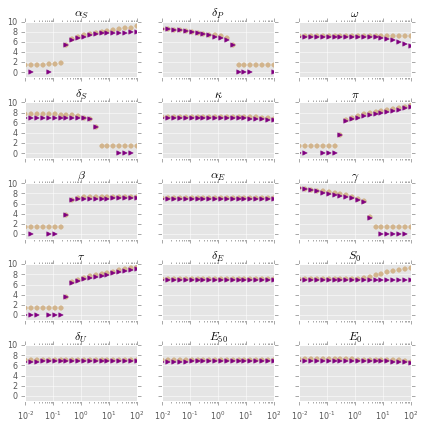

In [6]:
#theoretical exploration of parameter space
col1='tan'
col2='purple'

aS = 100;   #constant growth rate of susceptibles [cells/uL/day]
dS = 0.3;   #susceptible death rate [1/day] 
Bt = 1e-4;  #infectivity [cells/virion-day]
dI = 1;     #infected death rate [1/day]
k  = 0.01;  #immune cell killing rate [1/day]
w  = 0.01;     #immune cell multiplier [1/day]
aE = 1e-4;   #initial E cell concentration [cells/uL]
dE = 0.003;  #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]
tau= 0.05   #productively infected probability
p  = 5e4    #leak+burst viral production rate [virions/cell]
g  = 23      #viral clearance [1/day]
 

#initial conditions
U0=0; 
P0=0;
V0=0.03;    
S0=250; 
E0=1;       

guess = aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g,S0,E0
guess_bounds = [tuple(np.array(guess)/100),tuple(np.array(guess)*100)] #go over a wide range

#local sensitivity analysis
fig,axarr = plt.subplots(5,3,sharey=True,sharex=True,figsize=(6,6),dpi=600)
t=np.linspace(0,20*7,1e4)
range_mag=20 #number of values to choose in range
plot_range=np.logspace(-2,2,range_mag)

for i in range(len(guess)):
    rangez = np.logspace(np.log10(guess_bounds[0][i]),np.log10(guess_bounds[1][i]),range_mag) #make the logarithmic range between bounds by range_mag
    maxV=[]; spV=[]
    for j in range(range_mag):
        paramz=np.array(guess)
        paramz[i]=rangez[j]
        sol=odeint(model_1, [paramz[-2],U0,P0,paramz[-1],V0], t, tuple(paramz[0:-2]), mxstep=1000)
        Vj=sol[:,4]*1e3
        maxV.append(max(np.log10(Vj)))
        spV.append(np.log10(np.ceil(np.nanmean(Vj[-22:-1])))) #set point average over last 2 days rounded up to "undetectable"

    ax=axarr[i%5][int(np.floor(i/5))]
    ax.scatter(plot_range,maxV,color=col1,marker='o')#,lw=3)
    ax.scatter(plot_range,spV,color=col2,marker='>')#,lw=3)
    ax.set_xscale('log')
    ax.set_title(param_names[i],fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim([1e-2,1e2])
    ax.set_ylim([-1,10])

#plt.legend(['peak','wk20'],fontsize=8,loc=4)
plt.tight_layout()
plt.savefig('figures/local_sense.pdf')

In [93]:
#sensitivity analysis 

t0 = time.time()

sampz=1000
lhs_samples = pyDOE.lhs( int(len(param_names)), samples=sampz, criterion='center')
t=np.linspace(0,10*7,1e4)

plt.figure(figsize=(8,3),dpi=600)

maxV=[]; spV=[]; psv=[]
for i in range(sampz):
    
    #LHS linearly covering
    #lhs_list = np.array(guess_bounds[0])+lhs_samples[i]*(np.array(guess_bounds[1])-np.array(guess_bounds[0]))

    #LHS logarithmically covering
    lhs_list = 10**(np.log10(guess_bounds[0])+lhs_samples[i]*(np.log10(guess_bounds[1])-np.log10(guess_bounds[0])))

    #populate the lists with parameter ranges that actually make sense (set-point>1 copy/mL)
    #if max(Vj)<1e9 and min(Vj)>1: #VL should not go below 1 copy/mL or above 1e9 copy/mL
    R0=lhs_list[3]*lhs_list[2]/lhs_list[4]*lhs_list[0]/lhs_list[1]*lhs_list[11]/lhs_list[12]
    
    if R0>1:
        sol,outs=odeint(model_1, [lhs_list[-2],U0,P0,lhs_list[-1],V0], t, tuple(lhs_list[0:-2]), mxstep=1000, full_output=1)
        Vj=sol[:,4]*1e3
        psv.append(lhs_list) #parameter sampled values
        maxV.append(max(np.log10(Vj)))
        spV.append(np.mean(np.log10(Vj[-22:-1]))) #set point average over last 2 days
        #spV.append(np.log10(np.ceil(np.mean(Vj[-22:-1])))) #set point average over last 2 days rounded up to "undetectable"
        if sampz<100:
            #viral load CD4 and CD8
            plt.subplot(131)
            plt.semilogy(t,sol[:,4]*1e3,color='purple',alpha=0.3)
            plt.ylabel('viral load (copies/mL)')
            plt.xlabel('time (weeks)')
            plt.ylim([1e-4,1e9])
            plt.subplot(132)
            plt.semilogy(t,sol[:,0],color='slateblue',alpha=0.3)
            #plt.plot(t,sol[:,1],color='tan')
            #plt.semilogy(t,sol[:,2],color='firebrick')
            #plt.legend(['S','U','P'],fontsize=8,loc=1)
            plt.ylabel('susceptible cells (cells/$\mu$L)')
            plt.xlabel('time (weeks)')
            plt.ylim([1e-2,1e5])
            plt.subplot(133)
            plt.semilogy(t,sol[:,3],color='limegreen',alpha=0.3)
            plt.ylabel('cytolytic response (cells/$\mu$L)')
            plt.xlabel('time (weeks)')
            plt.ylim([1e-2,1e4])

if sampz<100:
    plt.tight_layout()
    plt.savefig('figures/example_LHS.pdf')  # No warning now

t1 = time.time()
print(str(sampz) + ' samples took ' + str(np.round(t1-t0,2)) + ' seconds')


1000 samples took 11.81 seconds


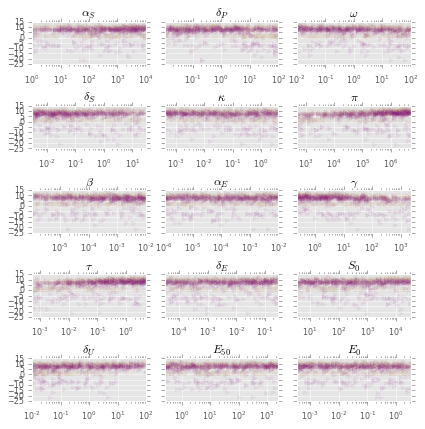

In [95]:
#loop through each variable and plot correlation scatter plots and calculate coefficients
#this uses the data from before that eliminates unrealistic VLs

max_corr=[]; sp_corr=[] #correlation coefficient holders
fig,axarr = plt.subplots(5,3,sharey=True,sharex=False,figsize=(6,6),dpi=600)
for i in range(len(lhs_list)):
    ax=axarr[i%5][int(np.floor(i/5))]
    rangez=[psv[j][i] for j in range(len(psv))]
    ax.scatter(rangez,maxV,color=col1,marker='o',alpha=0.05)#,lw=3)
    ax.scatter(rangez,spV,color=col2,marker='>',alpha=0.05)#,lw=3)
    ax.set_xscale('log')
    ax.set_title(param_names[i],fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim([min(rangez),max(rangez)])
    
    #calculate correlations
    max_corr.append(spearmanr(rangez,maxV)[0])
    sp_corr.append(spearmanr(rangez,spV)[0])
    
#ax.set_ylim([0,10])

plt.tight_layout()
plt.gcf().savefig('figures/corrscatters.pdf')  # No warning now


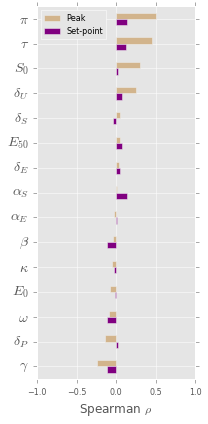

In [99]:

#sort the variable names
indz=np.array(max_corr).argsort()
sorted_nms=[]
sorted_max=[]
sorted_set=[]
for kk in range(len(param_names)):
    sorted_nms.append(param_names[indz[kk]])
    sorted_max.append(max_corr[indz[kk]])
    sorted_set.append(sp_corr[indz[kk]])
      
#correlation coefficient bar plots
plt.figure(figsize=(3,6),dpi=600)
bspace=np.arange(0,len(lhs_list)*2,2)
    
plt.barh(bspace+0.5,sorted_max,0.5,color=col1)
plt.barh(bspace,sorted_set,0.5,color=col2)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r'Spearman $\rho$',fontsize=12)
plt.yticks(bspace+0.5,sorted_nms)
plt.legend(['Peak','Set-point'],fontsize=8,loc=2)
plt.ylim([-0.5,bspace[-1]+1.5])   

plt.gcf().set_tight_layout(True)
plt.gcf().savefig('corrbars.pdf')




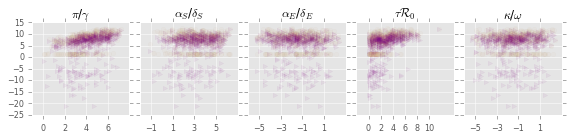

In [117]:
#let's also check obvious combinations

combos=[
    param_names[11]+str('/')+param_names[12],
    param_names[0]+str('/')+param_names[1],
    param_names[7]+str('/')+param_names[8],
    r'$\tau\mathcal{R}_0$',
    param_names[6]+str('/')+param_names[10],
       ]
        
combo_max_corr=[]; combo_sp_corr=[] #correlation coefficient holders
fig,axarr = plt.subplots(1,5,sharey=True,sharex=False,figsize=(8,2),dpi=600)

for i in range(len(combos)):
    if i==0:
        #p/g
        comb=[psv[j][11]/psv[j][12] for j in range(len(psv))]   
    elif i==1:
        #aS/dS
        comb=[psv[j][0]/psv[j][1] for j in range(len(psv))]   
    elif i==2:
        #aE/dE
        comb=[psv[j][7]/psv[j][8] for j in range(len(psv))]   
    elif i==3:
        #\tau*Ro
        comb=[psv[j][3]*psv[j][2]/psv[j][4]*psv[j][0]/psv[j][1]*psv[j][11]/psv[j][12] for j in range(len(psv))]   
    elif i==4:
        #w/k
        comb=[psv[j][6]/psv[j][10] for j in range(len(psv))]   
    
    ax=axarr[i]
    ax.scatter(np.log10(comb),maxV,color=col1,marker='o',alpha=0.05)#,lw=3)
    ax.scatter(np.log10(comb),spV,color=col2,marker='>',alpha=0.05)#,lw=3)
    ax.set_title(combos[i],fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks(range(int(min(np.log10(comb))),int(max(np.log10(comb)))+1,2))

    combo_max_corr.append(spearmanr(comb,maxV)[0])
    combo_sp_corr.append(spearmanr(comb,spV)[0])

plt.tight_layout()
plt.gcf().savefig('corrscatters_combos.pdf')  # No warning now



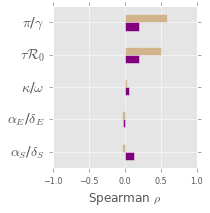

In [108]:
#sort the variable names
indz=np.array(combo_max_corr).argsort()
sorted_nms=[]
sorted_max=[]
sorted_set=[]
for kk in range(len(combos)):
    sorted_nms.append(combos[indz[kk]])
    sorted_max.append(combo_max_corr[indz[kk]])
    sorted_set.append(combo_sp_corr[indz[kk]])
      
#correlation coefficient bar plots
plt.figure(figsize=(3,3),dpi=600)
bspace=np.arange(0,len(combos)*2,2)
    
plt.barh(bspace+0.5,sorted_max,0.5,color=col1)
plt.barh(bspace,sorted_set,0.5,color=col2)
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r'Spearman $\rho$',fontsize=12)
plt.yticks(bspace+0.5,sorted_nms)
#plt.legend(['Peak','Set-point'],fontsize=12,loc=1)
plt.ylim([-0.5,bspace[-1]+1.5])   

plt.tight_layout()
plt.gcf().savefig('corrbars_combos.pdf')


